In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Load and preprocess the dataset
def load_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    
    # Store and binarize labels
    label_binarizer = LabelBinarizer()
    train_labels = label_binarizer.fit_transform(train['label'])
    test_labels = label_binarizer.transform(test['label'])
    
    # Drop labels from the datasets
    train.drop('label', axis=1, inplace=True)
    test.drop('label', axis=1, inplace=True)
    
    # Reshape images
    train_images = np.array([np.reshape(i, (28, 28, 1)) for i in train.values]) / 255.0
    test_images = np.array([np.reshape(i, (28, 28, 1)) for i in test.values]) / 255.0
    
    return train_images, train_labels, test_images, test_labels

In [3]:
# Build the CNN model
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model


In [4]:
# Plot accuracy and loss during training
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [5]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [6]:
# Real-time gesture recognition using the webcam
def get_letter(result):
    class_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
                    9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R',
                    17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y'}
    return class_labels.get(int(result), "Error")

In [7]:
def recognize_gesture(model):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open video capture.")
        return

    while True:
        ret, frame = cap.read()
        roi = frame[100:400, 320:620]
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        roi_resized = cv2.resize(roi_gray, (28, 28), interpolation=cv2.INTER_AREA)
        roi_reshaped = roi_resized.reshape(1, 28, 28, 1) / 255.0
        
        # Predict gesture
        prediction = np.argmax(model.predict(roi_reshaped), axis=1)
        gesture = get_letter(prediction[0])

        # Display the result
        cv2.rectangle(frame, (320, 100), (620, 400), (255, 0, 0), 2)
        cv2.putText(frame, f'Gesture: {gesture}', (320, 90), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("Frame", frame)

        if cv2.waitKey(1) & 0xFF == 13:  # Press 'Enter' to exit
            break

    cap.release()
    cv2.destroyAllWindows()


In [8]:
def main():
    train_path = r"C:\Users\Abhinav Samantara\Downloads\dl1\sign_mnist_train\sign_mnist_train.csv"
    test_path = r"C:\Users\Abhinav Samantara\Downloads\dl1\sign_mnist_test\sign_mnist_test.csv"
    
    # Load data
    x_train, y_train, x_test, y_test = load_data(train_path, test_path)

    # Build model
    model = build_model(input_shape=(28, 28, 1), num_classes=24)

    # Train model
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=128, verbose=2)

    # Plot accuracy and loss
    plot_training_history(history)

    # Evaluate on test set
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f'Test Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%')

    # Plot confusion matrix
    class_labels = [chr(i) for i in range(65, 90) if chr(i) not in ['J', 'Z']]
    plot_confusion_matrix(y_true, y_pred, classes=class_labels)

    # Save the model
    model.save("sign_mnist_cnn_improved.h5")
    print("Model Saved")

    # Real-time gesture recognition
    recognize_gesture(model)


C:\Users\Abhinav Samantara\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
215/215 - 15s - 71ms/step - accuracy: 0.2419 - loss: 2.4425 - val_accuracy: 0.5923 - val_loss: 1.4286
Epoch 2/20
215/215 - 11s - 50ms/step - accuracy: 0.6642 - loss: 0.9899 - val_accuracy: 0.7115 - val_loss: 0.8293
Epoch 3/20
215/215 - 11s - 50ms/step - accuracy: 0.8160 - loss: 0.5446 - val_accuracy: 0.8158 - val_loss: 0.5559
Epoch 4/20
215/215 - 11s - 50ms/step - accuracy: 0.8947 - loss: 0.3127 - val_accuracy: 0.8335 - val_loss: 0.4771
Epoch 5/20
215/215 - 21s - 98ms/step - accuracy: 0.9381 - loss: 0.1946 - val_accuracy: 0.8500 - val_loss: 0.4530
Epoch 6/20
215/215 - 11s - 50ms/step - accuracy: 0.9639 - loss: 0.1156 - val_accuracy: 0.8551 - val_loss: 0.4947
Epoch 7/20
215/215 - 10s - 48ms/step - accuracy: 0.9762 - loss: 0.0827 - val_accuracy: 0.8479 - val_loss: 0.4752
Epoch 8/20
215/215 - 11s - 49ms/step - accuracy: 0.9850 - loss: 0.0539 - val_accuracy: 0.8760 - val_loss: 0.4207
Epoch 9/20
215/215 - 11s - 51ms/step - accuracy: 0.9895 - loss: 0.0389 - val_accuracy: 0.8656 - 

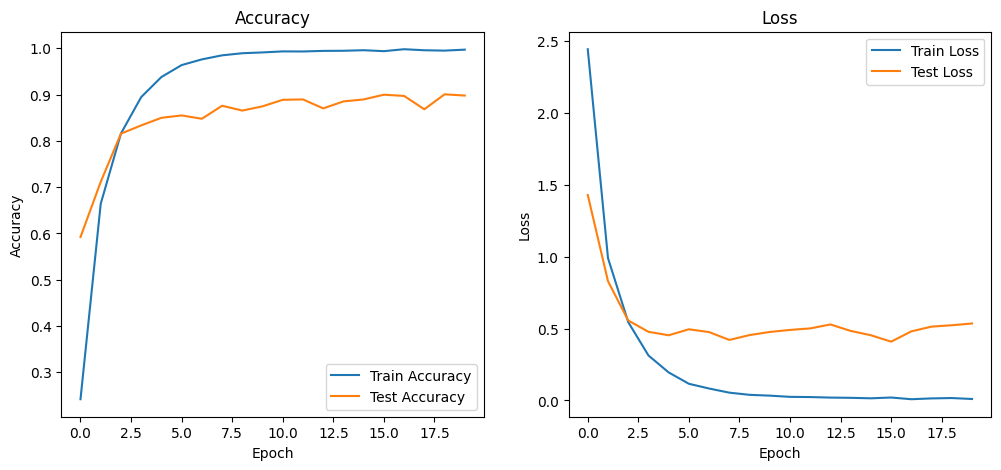

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Test Accuracy: 89.81%


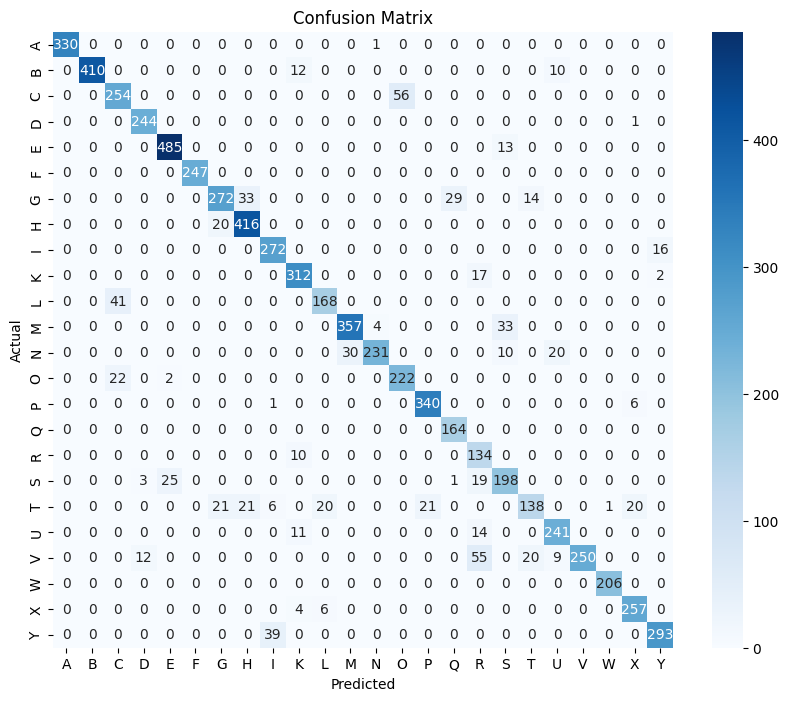

Model Saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [ ]:
# Ensure this line is after the definition of the `main` function
if __name__ == '__main__':
    main()